<a href="https://colab.research.google.com/github/IanCramer/Arr.js-Testing/blob/master/Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Expectations of Students
*   Try mutliple classifiers
*   Hyper parameter optimization
*   Thoughtful feature selection and/or feature construction
*   An F1 score higher than .75 is considered good.

In [ ]:
import os
import pandas as pd
import numpy as np

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
nltk.download('vader_lexicon')

# Installs and imports Hugging Face sentiment analysis tools
!pip install -q transformers
from transformers import pipeline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 26.2 MB/s eta 0:00:00


In [ ]:
# Sentiment analysis using the default model (distilbert-base-uncased-finetuned-sst-2-english)
# classifier = pipeline('sentiment-analysis')
# result = classifier('I am very happy today!')
# print(result)

# # Sentiment analysis using the 'bert-base-cased' model
# classifier = pipeline('sentiment-analysis', model='bert-base-cased', tokenizer='bert-base-cased')
# result = classifier('I am very happy today!')
# print(result)

# # Sentiment analysis using the 'distilbert-base-uncased' model
# classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased', tokenizer='distilbert-base-uncased')
# result = classifier('I am very happy today!')
# print(result)

# # Sentiment analysis using the 'nlptown/bert-base-multilingual-uncased-sentiment' model for multiple languages
# classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')
# result = classifier('Je suis très heureux aujourd\'hui!', lang='fr')
# print(result)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.999875545501709}]


In [ ]:
# Old
def experiment_data(category, features):
    # Old Path
    path = '/content/drive/MyDrive/1. School and Education/2020-2023 Northwestern/2023_Q2_Spring/CS 349 (TA)/Project/divided_datasets/'

    cols = features + ['awesomeness']

    # Load Training Data
    train = pd.read_json(f'{path}{category}_train.json')[cols]
    train = add_sentiment_nltk(train.fillna(''))

    # Load Testing Data
    tests = []
    for i in range(1,4):
        test = pd.read_json(f'{path}{category}_test{i}.json')[cols]
        test = add_sentiment_nltk(test.fillna(''))
        tests.append(test)

    return train, tests

In [ ]:
# New
def project_data(category, cols):
    # New Path
    path = '/content/drive/MyDrive/1. School and Education/2020-2023 Northwestern/2023_Q2_Spring/CS 349 (TA)/Project/divided_datasets_v2/'

    train_reviews = pd.read_json(f'{path}{category}/train/review_training.json')
    train_products = pd.read_json(f'{path}{category}/train/product_training.json')
    train = group_merge_data(train_reviews, train_products, cols, 'asin')

    test1_reviews = pd.read_json(f'{path}{category}/test1/review_test.json')
    test1_products = pd.read_json(f'{path}{category}/test1/product_test.json')
    test1 = group_merge_data(test1_reviews, test1_products, cols, 'asin')

    test2_reviews = pd.read_json(f'{path}{category}/test2/review_test.json')
    test2_products = pd.read_json(f'{path}{category}/test2/product_test.json')
    test2 = group_merge_data(test2_reviews, test2_products, cols, 'asin')

    test3_reviews = pd.read_json(f'{path}{category}/test3/review_test.json')
    test3_products = pd.read_json(f'{path}{category}/test3/product_test.json')
    test3 = group_merge_data(test3_reviews, test3_products, cols, 'asin')

    return train, test1, test2, test3


In [ ]:
def group_merge_data(df1, df2, cols, on_col):
    grouped = df1.groupby(on_col).agg(lambda x: ' '.join(x.astype(str))).reset_index()
    grouped = grouped[cols]
    df2 = pd.merge(df2, grouped, on=on_col, how='left')
    return df2

In [ ]:
def add_sentiment_nltk(df):
    sid = SentimentIntensityAnalyzer()
    df['reviewText_sentiment'] = df['reviewText'].apply(lambda x: sid.polarity_scores(x)['compound'])
    df['summary_sentiment'] = df['summary'].apply(lambda x: sid.polarity_scores(x)['compound'])
    return df




def add_sentiment_transformers(df):
    set_seed(42) # for reproducibility
    
    # initialize sentiment analysis pipeline
    sentiment_analyzer = pipeline('sentiment-analysis')
    
    # process reviews and summaries in batches of 512 to avoid running out of memory
    batch_size = 512
    
    # process reviews in batches
    review_scores = []
    for i in range(0, len(df), batch_size):
        batch = df['reviewText'].iloc[i:i+batch_size].tolist()
        scores = sentiment_analyzer(batch, truncation=True, padding=True)
        review_scores.extend([score['score'] for score in scores])
    df['reviewText_sentiment'] = review_scores
    
    # process summaries in batches
    summary_scores = []
    for i in range(0, len(df), batch_size):
        batch = df['summary'].iloc[i:i+batch_size].tolist()
        scores = sentiment_analyzer(batch, truncation=True, padding=True)
        summary_scores.extend([score['score'] for score in scores])
    df['summary_sentiment'] = summary_scores
    
    return df


In [ ]:
def vectorize(df, vectorizer=None):
    if not vectorizer:
        # Construct the Vectorizer    
        vectorizer = CountVectorizer()

        # Vectorize and Transform the data
        X_text = df.apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
        X = vectorizer.fit_transform(X_text)
        return X, vectorizer
    
    assert vectorizer.vocabulary_ is not None
    # Apply the vectorization and transformation from training to the data
    X_text = df.apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
    X = vectorizer.transform(X_text)
    return X, vectorizer

In [ ]:
# Perform 10-fold cross validation training that searches for optimal hyper parameters
def k_fold_cross_val_fit(model, params, X, y, k):
    grid_search = GridSearchCV(nb, params, cv=k)
    grid_search.fit(X, y)
    print("Best hyperparameters:", grid_search.best_params_)
    return grid_search.best_estimator_

In [ ]:
def run_test(model, data, vectorizer):
    X, vectorizer = vectorize(data, vectorizer)
    data['prediction'] = model.predict(X)
    return data[['asin', 'prediction']].groupby('asin').agg(lambda x: x.mode()[0]).reset_index()

In [ ]:
def measure_performance(targets, predictions):
    targets = targets[['asin', 'awesomeness']].groupby('asin').agg(lambda x: x.iloc[0]).reset_index()

    y = targets['awesomeness'].values
    z = predictions['prediction'].values

    labels = ['not awesome', 'awesome']
    print(classification_report(y, z, target_names=labels))
    ConfusionMatrixDisplay(confusion_matrix(y, z), display_labels=labels).plot()

In [ ]:
def run_experiment(category, features, model, params):
    print(f'Using a {model.__class__.__name__}')
    print(f'with input features {features}')
    print(f'to classify awesomeness on the {category} dataset')
    print()


    # Load Data
    print("Loading Data")
    train, tests = experiment_data(category, features)


    # Construct the vectorizer for vectorizing text data
    print("Vectorizing")
    vectorizer = CountVectorizer()

    # Vectorize and Transform the data
    train_X, vectorizer = vectorize(train[features])
    train_y = train['awesomeness']

    # Use 10 fold cross validation to find the best hyper parameters for the model
    print("Cross Validating for hyper parameter optimization")
    model = k_fold_cross_val_fit(model, params, train_X, train_y, 10)


    # Fit the model on the entier training set
    print("Training")
    model.fit(train_X, train_y)


    # Test the model on each test and measure its performance
    print("Testing")
    for i,test in enumerate(tests):
        predictions = run_test(model, test[features], vectorizer)
        print(f"==== results on test set {i} ====== \n ")
        measure_performance(test, predictions)

    return tests, predictions

In [ ]:
# Construct a MultinomialNB Classifier
nb = MultinomialNB()
# Set the hyperparameters to be tuned during cross validation training
nb_params = {'alpha': [1*10**-10, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0],
              'fit_prior': [True, False]}

In [ ]:
svm = LinearSVC()
svm_params = {'C': [1*10**-10, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0],
              'gamma': [1*10**-10, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0],
              'kernel': ['linear', 'rbf']}

In [ ]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [ ]:
# Categories: ['Automotive', 'CDs_and_Vinyl', 'Cell_Phones_and_Accessories', 'Grocery_and_Gourmet_Food', 'Sports_and_Outdoors', 'Toys_and_Games']
category = 'Grocery_and_Gourmet_Food'

# Columns: 
features = ['asin', 'reviewerID', 'verified', 'reviewerName', 'reviewText', 'summary', 'reviewText_senitment', 'summary_sentiment']
model = nb
params = nb_params

### Experiements to Run
*   Grouped Data vs Ungrouped
*   No Sentiment vs NLTK Sentiment vs Transformers Sentiment
*   Feature Selection
*   Multiple Models

Using a MultinomialNB with input features ['asin', 'reviewerID', 'verified', 'reviewerName', 'reviewText', 'summary'] to classify awesomeness on the Grocery_and_Gourmet_Food dataset
Loading Data
Vectorizing
Cross Validating for hyper parameter optimization
Best hyperparameters: {'alpha': 0.1, 'fit_prior': True}
Training
Testing
==== results on test set 0 ====== 
 
              precision    recall  f1-score   support

 not awesome       0.89      0.94      0.91     17314
     awesome       0.93      0.88      0.91     17027

    accuracy                           0.91     34341
   macro avg       0.91      0.91      0.91     34341
weighted avg       0.91      0.91      0.91     34341

==== results on test set 1 ====== 
 
              precision    recall  f1-score   support

 not awesome       0.89      0.93      0.91     15122
     awesome       0.92      0.88      0.90     14875

    accuracy                           0.91     29997
   macro avg       0.91      0.91      0.91     299

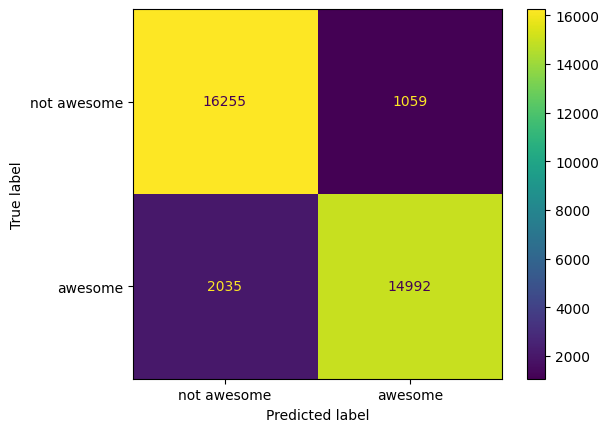

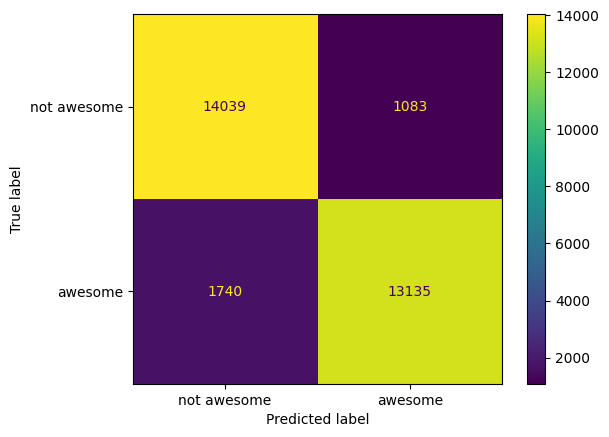

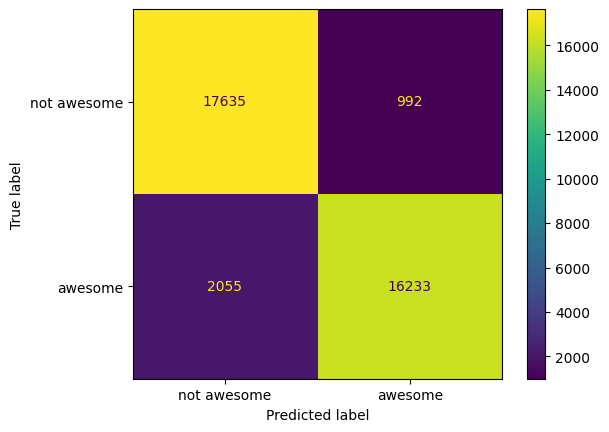

In [ ]:
test, predictions = run_experiment(category, features, model, params)